In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, fbeta_score, classification_report, ConfusionMatrixDisplay, DetCurveDisplay, RocCurveDisplay, det_curve, roc_curve
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline

In [5]:
full_data = pd.read_csv("../data/processed/full_all_day_ahead.csv")
full_data.head()

cols_1_day_ahead = [c for c in full_data.columns if c == "Abnormal" or c.endswith("_1")]
data_1da = full_data[cols_1_day_ahead]

# data_1da[data_1da.isna().any(axis=1)]

data_1da = data_1da.dropna()
X_1da = data_1da.drop(columns="Abnormal")
y_1da = data_1da["Abnormal"]

## RR_1 appears to always have same value
X_1da["RR_1"].unique()
X_1da = X_1da.drop(columns="RR_1")

y_bin = LabelEncoder().fit_transform(y_1da)

# Test-train split
np.random.seed(7406)
X_train, X_test, y_train, y_test = train_test_split(X_1da, y_bin, train_size=0.7, stratify=y_bin)

## SMOTE and PCA

In [6]:
smote = SMOTE(n_jobs=-1, k_neighbors=10)
X_rs, y_rs = smote.fit_resample(X_train, y_train)

c:\Users\willc\OneDrive\OMSA\03 SP24 ISYE7406 DMSL\Project\dmsl-project\env\Lib\site-packages\imblearn\over_sampling\_smote\base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [7]:
pca = PCA()
pca.fit(StandardScaler().fit_transform(X_rs))
pca.explained_variance_ratio_.cumsum()

array([0.36366318, 0.61471538, 0.73615156, 0.80226507, 0.86171149,
       0.91271891, 0.94930088, 0.97549774, 0.99194757, 0.99862592,
       0.9993682 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

## Model Building

In [8]:
len(X_rs)**0.5
[k for k in range(5, 60, 6)]

[5, 11, 17, 23, 29, 35, 41, 47, 53, 59]

In [10]:
kf = StratifiedKFold(n_splits=10, shuffle=True)
scaler = StandardScaler()

pipeline = Pipeline([("scaler", scaler),
                     ("svc", SVC(break_ties=True))])

param_grid = [{
  "svc__C": [0.001, 0.01, 0.1, 1, 10, 100],
  "svc__kernel": ["linear"]
}, {
  "svc__C": [0.001, 0.01, 0.1, 1, 10, 100],
  "svc__gamma": [0.0001, 0.001, 0.01, 0.1, "scale", "auto"],
  "svc__kernel": ["rbf"]
}]
grid_search = GridSearchCV(pipeline, param_grid, scoring=make_scorer(fbeta_score, beta=2), cv=kf, refit=True)
grid_search.fit(X_rs, y_rs)
print(grid_search.best_params_)

{'svc__C': 100, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


## Metrics

0.9993201903467029
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1764
           1       1.00      1.00      1.00      1764

    accuracy                           1.00      3528
   macro avg       1.00      1.00      1.00      3528
weighted avg       1.00      1.00      1.00      3528



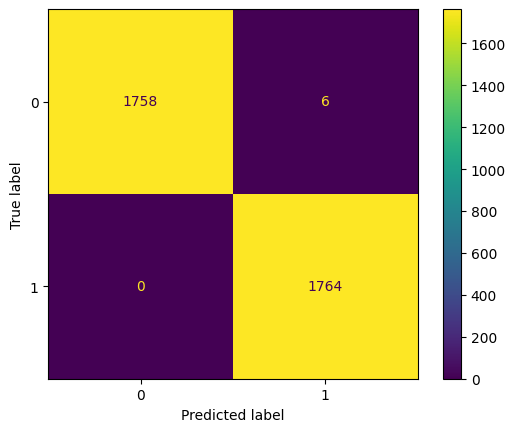

In [11]:
y_train_pred = grid_search.predict(X_rs)
y_test_pred = grid_search.predict(X_test)

print(fbeta_score(y_rs, y_train_pred, beta=2))
print(classification_report(y_rs, y_train_pred))
ConfusionMatrixDisplay.from_predictions(y_rs, y_train_pred)

0.2112676056338028
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       756
           1       0.11      0.27      0.16        11

    accuracy                           0.96       767
   macro avg       0.55      0.62      0.57       767
weighted avg       0.98      0.96      0.97       767



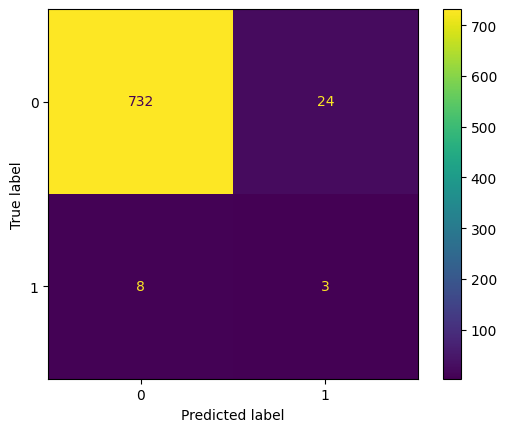

In [12]:
print(fbeta_score(y_test, y_test_pred, beta=2))
print(classification_report(y_test, y_test_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

In [13]:
pca_pipeline = pipeline = Pipeline([("scaler", scaler),
                                    ("pca", PCA(n_components=6)),
                                    ("svc", SVC(break_ties=True))])

pca_grid_search = GridSearchCV(pipeline, param_grid, scoring=make_scorer(fbeta_score, beta=2), cv=kf, refit=True)
pca_grid_search.fit(X_rs, y_rs)
print(pca_grid_search.best_params_)

{'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}


0.9928877850530594
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1764
           1       0.98      1.00      0.99      1764

    accuracy                           0.99      3528
   macro avg       0.99      0.99      0.99      3528
weighted avg       0.99      0.99      0.99      3528



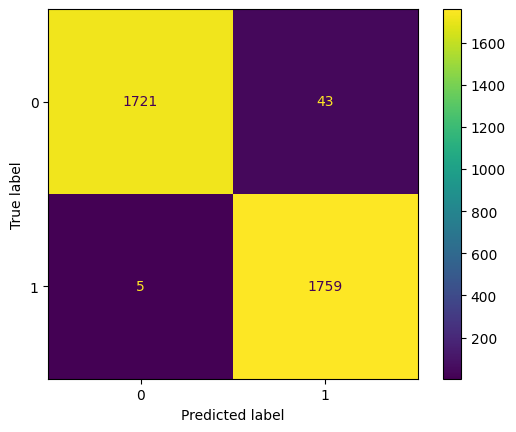

In [14]:
y_train_pred = pca_grid_search.predict(X_rs)
y_test_pred = pca_grid_search.predict(X_test)

print(fbeta_score(y_rs, y_train_pred, beta=2))
print(classification_report(y_rs, y_train_pred))
ConfusionMatrixDisplay.from_predictions(y_rs, y_train_pred)

0.1744186046511628
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       756
           1       0.07      0.27      0.11        11

    accuracy                           0.94       767
   macro avg       0.53      0.61      0.54       767
weighted avg       0.98      0.94      0.96       767



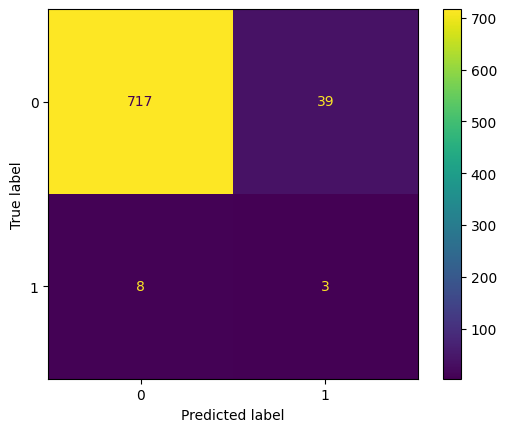

In [15]:
print(fbeta_score(y_test, y_test_pred, beta=2))
print(classification_report(y_test, y_test_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)